In [139]:
import xlwings as xw
import os
import pandas as pd
import numpy as np
import datetime

# задание 1
На листе "Рецептура" файла себестоимостьА_в1.xlsx для области "Пшеничный хлеб" рассчитать 
себестоимость всех видов продукции.

In [146]:
a = xw.Book(r'C:\\Users\\Влад\\себестоимостьА_в1.xlsx')
ws = a.sheets[0]
table = ws['рцп_пшеничный_хлеб'].options(empty=0)
values = table.value
values_prices = [i for i in values if i[0] == 'Цена ресурсов, руб.'][0]
values_prices = values_prices[5:-4]
values_resourses = values[3:7]
for i in range(len(values_resourses)):
    values_resourses[i] = values_resourses[i][5:-4]

sums = []
for el in values_resourses:
    sum = 0
    for i in range(len(el)):
        sum += el[i]*values_prices[i]
    sums.append(sum)
sums

[21.48, 16.525, 17.423000000000002, 18.085]

# задание 2
Результаты расчетов 1.1 сохранить в отдельном столбце области "Пшеничный хлеб"

In [94]:
ws['P7'].options(transpose=True).value = sums

# задание 3
Приблизить форматирование столбца, добавленного в задаче 2 к оформлению всей области

In [96]:
ws['P5'].value = 'Себестоимость единицы продукции'

# Сама лабораторная
№1 Загрузите данные из файлов reviews_sample.csv (ЛР2) и recipes_sample.csv (ЛР5) в виде pd.DataFrame. Обратите внимание на корректное считывание столбца(ов) с индексами. Оставьте в таблице с рецептами следующие столбцы: id, name, minutes, submitted, description, n_ingredients

In [53]:
reviews = pd.read_csv(r'C:\\Users\\Влад\\reviews_sample.csv')
reviews.rename(columns={reviews.columns[0] : 'index'}, inplace=True)
recipes = pd.read_csv(r'C:\\Users\\Влад\\recipes_sample.csv')
recipes = recipes.drop('contributor_id', axis=1)

# задание 2
Случайным образом выберите 5% строк из каждой таблицы и сохраните две таблицы на разные листы в один файл recipes.xlsx. Дайте листам названия "Рецепты" и "Отзывы", соответствующие содержанию таблиц.

In [54]:
import random
randoms = random.sample(range(0, len(recipes)), int(len(recipes)/20))
randoms1 = random.sample(range(0, len(reviews)), int(len(reviews)/20))

In [57]:
import openpyxl
f = r'C:\\Users\\Влад\\Desktop\\учеба\\тод\\лр4\\data\\recipes.xlsx'
#wb = openpyxl.Workbook()
#wb.save(f)
######## создал файл
recipes['submitted'] = pd.to_datetime(recipes['submitted'])
reviews['date'] = pd.to_datetime(reviews['date'])
file = xw.Book(f)
file.sheets[0].name = "Рецепты"
#file.sheets.add(name="Отзывы", after=file.sheets[0].name)
ws = file.sheets[0]
ws1 = file.sheets[1]
lst = [recipes.loc[rand] for rand in randoms]
df = pd.DataFrame(lst)
ws.activate()
ws['A1'].options(index=False).value = df
ws['D:D'][1:].number_format = 'ДД.ММ.ГГГГ'
ws['E:E'][1:].number_format = '0'

ws1.activate()
lst1 = [reviews.loc[rand] for rand in randoms1]
df1 = pd.DataFrame(lst1)
ws1['A1'].options(index=False).value = df1
ws1['E:E'][1:].number_format = '0'

# Задание 3
Используя xlwings, добавьте на лист Рецепты столбец seconds_assign, показывающий время выполнения рецепта в секундах. Выполните задание при помощи присваивания массива значений диапазону ячеек.

In [58]:
seconds = [el*60 for el in df['minutes'].tolist()]
seconds = pd.DataFrame(seconds)
seconds.columns = ['seconds_assign']
ws[f'I1:I{len(df)}'].options(index=False).value = seconds

#  Задание 4
Используя xlwings, добавьте на лист Рецепты столбец seconds_formula, показывающий время выполнения рецепта в секундах. Выполните задание при помощи формул Excel.

In [59]:
ws['J1'].value = 'seconds_formula'
ws['J:J'][1:].formula = f'=C2 * 60'

#  Задание 5
Сделайте названия всех добавленных столбцов полужирными и выровняйте по центру ячейки.

In [60]:
ws['I1:J1'].font.bold = True
ws['I:J'].api.HorizontalAlignment = xw.constants.HAlign.xlHAlignCenter

#  Задание 6
Раскрасьте ячейки столбца minutes в соответствии со следующим правилом: если рецепт выполняется быстрее 5 минут, то цвет - зеленый; от 5 до 10 минут - жёлтый; и больше 10 - красный.

In [61]:
for el in ws['C:C'][1:].expand('down'):
    if el.value < 5:
        el.color = (0, 255, 0)
    elif el.value > 10:
        el.color = (255, 0, 0)
    else:
        el.color = (255, 255, 0)

# задание 7
Добавьте на лист Рецепты столбец n_reviews, содержащий кол-во отзывов для этого рецепта. Выполните задание при помощи формул Excel.

In [62]:
recipe_ids = []
for el in lst:   ### lst это индексы рецептов, которые в файл залил
    recipe_ids.append(el.id)  # вытащил id из рецептов
n_reviews = reviews.groupby('recipe_id').count()['review']

In [63]:
recipe_n_rev = []
for el in recipe_ids:   # это чтобы не делать всяких сортировок
    try:
        recipe_n_rev.append(n_reviews[el])
    except KeyError:
        recipe_n_rev.append(0)
for i in range(len(recipe_n_rev)):
    recipe_n_rev[i] = [recipe_n_rev[i]]

In [64]:
ws['K1'].value = 'n_reviews'
ws['K:K'][1:].expand('down').value = recipe_n_rev 

# 7.2
# задание 8
Напишите функцию validate(), которая проверяет соответствие всех строк из листа Отзывы следующим правилам:
Рейтинг - это число от 0 до 5 включительно
Соответствующий рецепт имеется на листе Рецепты
В случае несоответствия этим правилам, выделите строку красным цветом

In [154]:
def validate():
    recipe_id = ws['B:B'][1:].value
    for i, el in enumerate(ws1['A2'].expand().value):
        if el[2] not in recipe_id or not el[4] in [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]:
            st = f'A{i+1}' + ':' + f'F{i+1}'
            ws1.range(st).color = (255, 0, 0) 

In [155]:
validate()

# задание 9
В файле recipes_model.csv находится модель данных предметной области "рецепты". При помощи пакета csv считайте эти данные. При помощи пакета xlwings запишите данные на лист Модель книги recipes_model.xlsx, начиная с ячейки A2, не используя циклы. Сделайте скриншот текущего состояния листа и прикрепите в ячейку ноутбука.

In [156]:
import csv

In [182]:
file = r'C:\\Users\\Влад\\Desktop\\учеба\\тод\\лр4\\data\\recipes_model.csv'
data = []
with open(file, newline='') as csvfile:
    f = csv.reader(csvfile, quotechar='|')
    for row in f:
        data.append(row[0].split('\t'))

In [183]:
data

[['recipe',
  'name',
  'varchar(100)',
  'Y',
  'Р\xa0РµС†РµРїС‚',
  'РќР°Р·РІР°РЅРёРµ СЂРµС†РµРїС‚Р°',
  '',
  '',
  ''],
 ['recipe',
  'id',
  'serial',
  'N',
  'Р\xa0РµС†РµРїС‚',
  'ID СЂРµС†РµРїС‚Р°',
  'PK',
  '',
  ''],
 ['recipe',
  'minutes',
  'int',
  'Y',
  'Р\xa0РµС†РµРїС‚',
  'Р”Р»РёС‚РµР»СЊРЅРѕСЃС‚СЊ РІС‹РїРѕР»РЅРµРЅРёСЏ РІ РјРёРЅСѓС‚Р°С…',
  '',
  '',
  ''],
 ['recipe',
  'contributor_id',
  'int',
  'Y',
  'Р\xa0РµС†РµРїС‚',
  'ID Р°РІС‚РѕСЂР° СЂРµС†РµРїС‚Р°',
  'FK',
  'user',
  'id'],
 ['recipe',
  'submitted',
  'timestamp',
  'Y',
  'Р\xa0РµС†РµРїС‚',
  'Р”Р°С‚Р° РґРѕР±Р°РІР»РµРЅРёСЏ',
  '',
  '',
  ''],
 ['recipe',
  'n_steps',
  'int',
  'N',
  'Р\xa0РµС†РµРїС‚',
  'РљРѕР»-РІРѕ С€Р°РіРѕРІ СЂРµС†РµРїС‚Р°',
  '',
  '',
  ''],
 ['recipe',
  'description',
  'text',
  'N',
  'Р\xa0РµС†РµРїС‚',
  'РћРїРёСЃР°РЅРёРµ СЂРµС†РµРїС‚Р°',
  '',
  '',
  ''],
 ['recipe',
  'n_ingredients',
  'int',
  'N',
  'Р\xa0РµС†РµРїС‚',
  'РљРѕР»-РІРѕ РёРЅРіСЂРµРґРёРµРЅС‚РѕРІ РІ СЂРµС†Рµ

In [208]:
f = r'C:\\Users\\Влад\\Desktop\\учеба\\тод\\лр4\\data\\recipes_model.xlsx'
#wb = openpyxl.Workbook()
#wb.save(f)
with open(f) as csv_file:  
    book = xw.Book(f)
## создал файл, открыл библиотекой

In [209]:
book.sheets[0].name = 'Модель'
ws = book.sheets[0]

In [210]:
ws['A2'].expand().value = data 

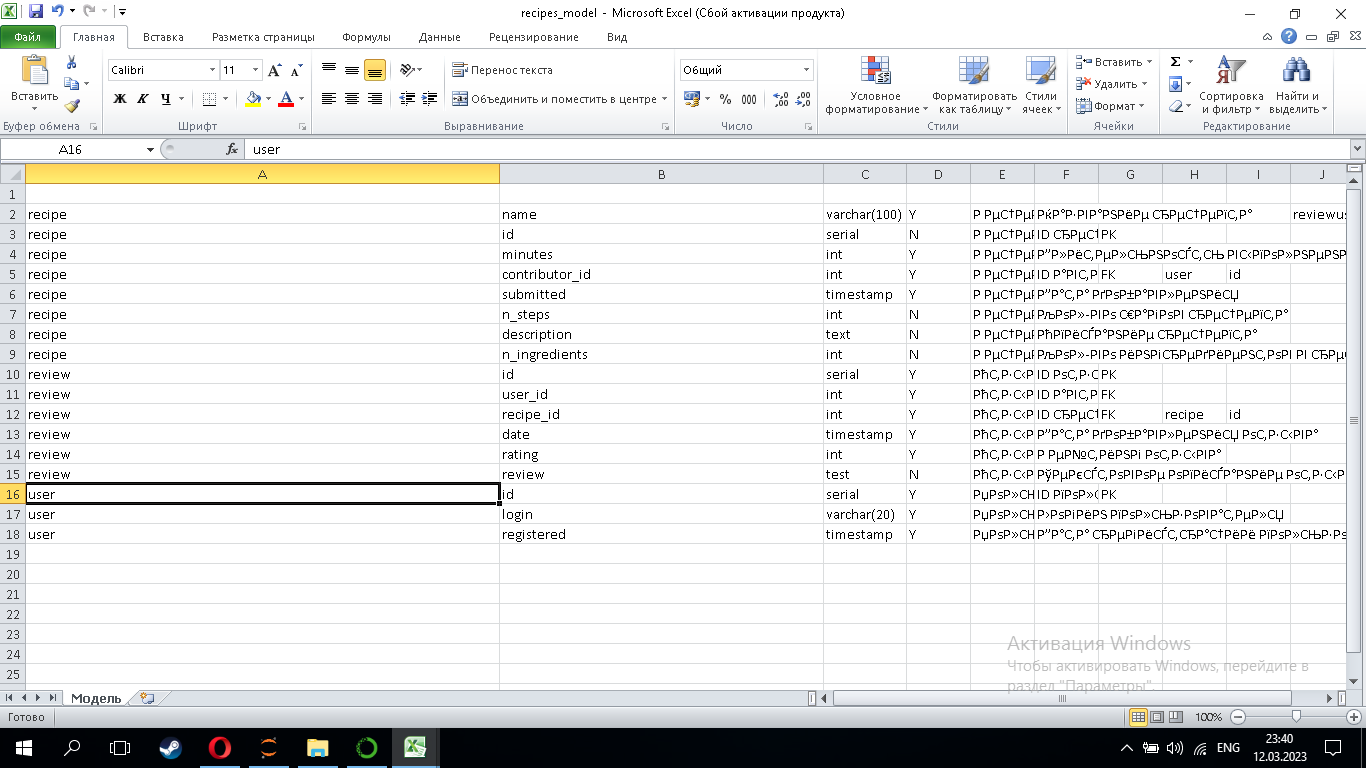

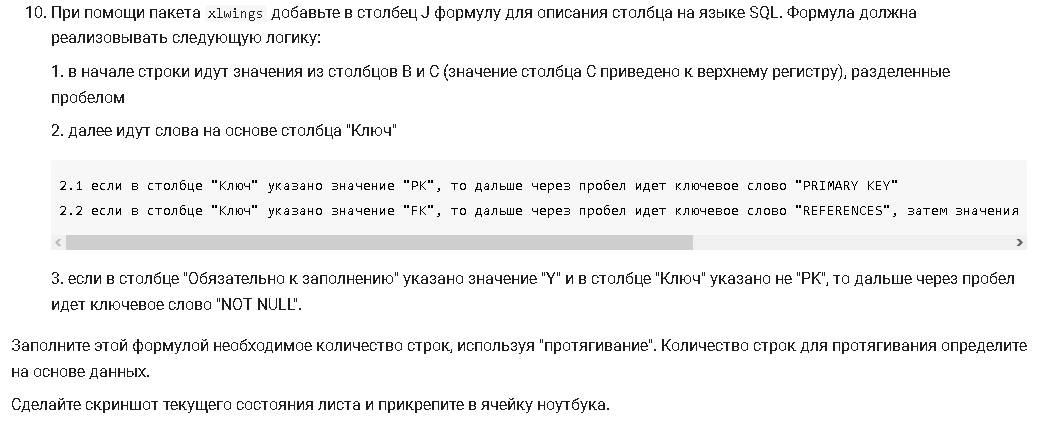

In [212]:
### тут должно работать, проверил внутри экселя, но почему-то библиотека ругается на индексы, так и не смог
### сделать, хотя выше прекрасно работало
fml = f'=CONCATENATE(B2;" ";UPPER(C2))&" "&IF(G2="PK";" PRIMARY KEY";IF(G2="FK";CONCATENATE(" REFERENCES ";H2;"(";I2;")");" "))&" "&IF(AND(D2="Y";G2<>"PK");"NOT NULL";" ")'
ws['J2:J18'].formula = fml

com_error: (-2147352567, 'Ошибка.', (0, None, None, None, 0, -2146827284), None)

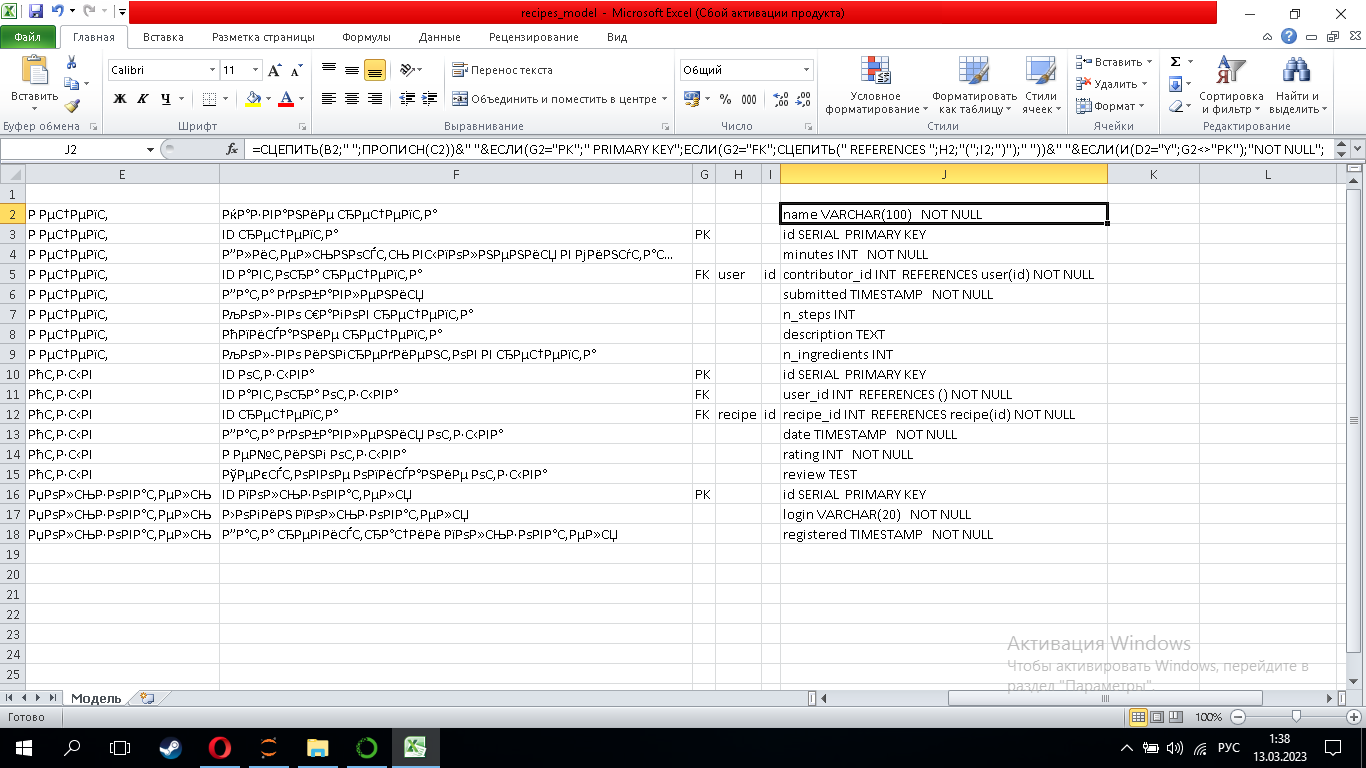

# Задание 11
При помощи пакета xlwings измените стилизацию листа Модель.
для заголовков добавьте заливку цвета 00ccff
примените автоподбор ширины столбца;
сделайте шрифт заголовков полужирным;
добавьте таблице автофильтр.
Сделайте скриншот текущего состояния листа и прикрепите в ячейку ноутбука.

Дальше я не знаю что делать, заголовки не считались(?), если открывать сам файл, он выглядит так же
В 12 задании вообще не понимаю сути